## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzipping the files and storing them into the folder

In [2]:
data_folder="/content/drive/MyDrive/Colab Notebooks/Data_Xray"
# import zipfile
# with zipfile.ZipFile(zip_fle, 'r') as zip_ref:
#     zip_ref.extractall(data_folder)

# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [3]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Dataset Path

In [4]:
DATASET_PATH="/content/drive/MyDrive/Colab Notebooks/Data_Xray/"

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

## Finding effisuon path and plotting theimage

In [5]:
effusion_path=os.path.join(DATASET_PATH , disease_cls[0],"*")
effusion_path

'/content/drive/MyDrive/Colab Notebooks/Data_Xray/effusion/*'

In [6]:
effusion=glob.glob(effusion_path)
effusion[0]

'/content/drive/MyDrive/Colab Notebooks/Data_Xray/effusion/00006592_000.png'

# Checking the total images in Effusion

In [7]:
# length of images in effusion
sm=0
for i in effusion:
  sm=sm+1
print(sm)


107


In [8]:
effusion = io.imread(effusion[0])
effusion.shape

(1024, 1024)

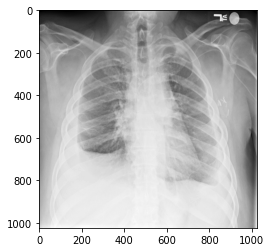

In [9]:
plt.imshow(effusion,cmap="gray")

## Similarly for the Nofinding Image

In [10]:

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

## Total images in normal

In [11]:
#normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal_pt = glob.glob(normal_path)
nm=0
for i in normal_pt:
  nm=nm+1
print(nm)

1000


### plotting both the images side by side

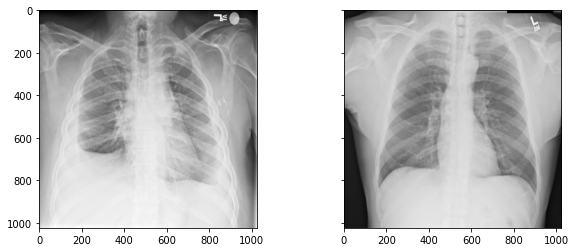

In [11]:
f,axes=plt.subplots(1,2,sharey=True)
f.set_figwidth(10)
axes[0].imshow(effusion,cmap="gray")
axes[1].imshow(normal,cmap="gray")

In [12]:
## checking shapes
print("Effusion Shape-",effusion.shape)
print("-"*100)
print("Normal Shape-",normal.shape)

Effusion Shape- (1024, 1024)
----------------------------------------------------------------------------------------------------
Normal Shape- (1024, 1024)


**The image here is 1 channel image havig a huge size (1024*1024)**
* Here we cant do center crop as the abnormality is not at the center its on the edges 

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

 1. Since image is to large 1024*1024, resizing it to 1/4 i.e(256,256), also note that the resolution also go down by doing this, but since our goal is detecting water conetent in lungs
2. we can manage, as high resolution will make computaion too slow
## Note that 
* resizing is always not a good idea for eg. we are looking for any anamoly in lungs for eg of size (2*2) pixel, in this case we we reduce the pixel to 0.2 the anamoly just disappear

In [13]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,) # X-ray are not vertical so we kept this as false

def preprocess_img(img, mode):
  # Nomalising the image
    img = (img - img.min())/(img.max() - img.min()) 
    # Since image is to large 1024*1024, resizing it to 1/4 i.e(256,256)
    # also note that the resolution also go down by doing this, but since our goal is detecting water conetent in lungs
    # we can manage, as high resolution will make computaion too slow 
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0: # selecting random images, if image is more than 0 augment them as we are using
                              # np.random.randn(), it throw random numbers having gaussian dist, num can be + or -
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [14]:
# Import resnet.py saved in google drive
import sys

#Say, resnet_dir is a directory where resnet.py is copied.

resnet_dir='/content/drive/MyDrive/Colab Notebooks'

sys.path.append(resnet_dir)

In [15]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

## using the same code as in flower recognisition

In [16]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X,keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [17]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1)

1/1 [==============================] - 8s 8s/step - loss: 1.6070 - accuracy: 0.7188


In [18]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5)

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 1.6983 - accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 1.4335 - accuracy: 0.9355
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 1.3838 - accuracy: 0.8710
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 1.3519 - accuracy: 0.8710
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 1.3280 - accuracy: 0.8750


### Overfitting on the Training Data

1. Let's now perform another important step which should be done before training the full-fledged model-  trying to **deliberately overfit the model** on a small dataset.

2. Here the loss is decrease from 1.69 to 1.32 and accuracy is increasing from .12 to .87, this is a good sign means the model is learning the pattern

# Important Observation
* Look accuracy after 2 nd 3 epoch i.e .903 drops to .87 its due too imbalace in `effusion` and `normal`
* The data class is highly imbalanced. The ratio of 'effusion' vs 'nofinding' is almost 10 (107/1000)

**As most of the data belongs to only one class, simply training in this scenario will not work as the model will learn mostly learn and classify most of the data as 'nofinding' resulting in high accuracy.  If you notice, around 90 per cent (1000/1107) of the data is 'nofinding' and if it classifies all the data as same, the accuracy will be 90 per cent which is close to 87 per cent accuracy which we have got. So, the objective to correctly classify the 'effusion'  is not fulfilled. The high accuracy clearly misleads us and therefore we will use AUC to validate the result.**


# Plotting the AUC Curve to know the actual performance of the model

In [19]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [20]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=40)
validation_generator = AugmentedDataGenerator('val', ablation=40)

auc_logger = roc_callback()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.9045
Val AUC for epoch0: 0.6058897243107769
11/11 [==============================] - 44s 4s/step - loss: 1.3275 - accuracy: 0.9045 - val_loss: 2.5596 - val_accuracy: 0.8906 - val_auc: 0.6059
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 1.2631 - accuracy: 0.9102
Val AUC for epoch1: 0.48563218390804597
11/11 [==============================] - 38s 4s/step - loss: 1.2631 - accuracy: 0.9102 - val_loss: 1.8699 - val_accuracy: 0.8906 - val_auc: 0.4856
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.9042
Val AUC for epoch2: 0.5488721804511278
11/11 [==============================] - 37s 3s/step - loss: 1.2722 - accuracy: 0.9042 - val_loss: 1.5505 - val_accuracy: 0.9062 - val_auc: 0.5489
Epoch 4/5
11/11 [==============================] - ETA: 0s - loss: 1.2690 - accuracy: 0.9042
Val AUC for epoch3: 0.6541666666666666
11/11 [=======================

**Here**
AUC score is around .5

# AUC-ROC Curve in Machine Learning Clearly Explained
What is the AUC-ROC curve?
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

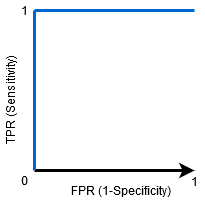

* When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.

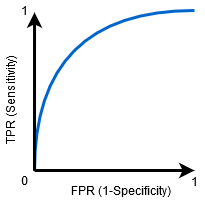

When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

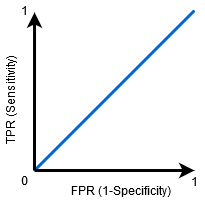

When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.

## To deal with this low prevelance problem we use
# Weighted Cross-Entropy

A common solution to the low prevalence rate problem is using a weighted cross-entropy loss. The loss is modified such that misclassifications of the low-prevalence class are penalised more heavily than the other class.

 

Therefore, every time the model makes an error on the abnormal class (in this case, ‘effusion’), we penalise it heavily by multiplying the loss by a high value of weights. This results in an increase in loss for misclassified classes and therefore the change in weights due to backpropagation is more. So, the learning curve for the weights responsible for misclassification is more. 

 

Let’s say “no finding” is class 0 and “effusion” is class 1.

bin_weights[0,0]:  Actual class: 0, Predicted class: 0, so no penalty, just normal weight of 1. 

bin_weights[1,1]:  Actual class: 1, Predicted class: 1, so no penalty, just normal weight of 1. 

 

In case of abnormality: 

bin_weights[1,0] - Actual class is 1, Predicted class is 0, penalise by weight of 5.

bin_weights[0,1] - Actual class is 0, Predicted class is 1, penalise by weight of 5.

In [21]:
from functools import partial
import keras.backend as K
from itertools import product
import numpy as np

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5 # peanlizing more on the misclassified one
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [22]:
## Runnig ablation experiment again
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=1)


1/1 [==============================] - 5s 5s/step - loss: 6.6496 - accuracy: 0.0968


## 4. Final Run
After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [48]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}): # Taken LR low as 1/4 coz model is not traing well
        new_lr = self.base_lr * (0.35 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [51]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = tf.keras.optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=100)
validation_generator = AugmentedDataGenerator('val', ablation=100)


# creating model checkpoint to store the best model
auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 2.2825 - accuracy: 0.4557
Val AUC for epoch0: 0.5517441860465115

Epoch 00001: val_accuracy improved from -inf to 0.90625, saving model to models/best_model.hdf5
27/27 [==============================] - 98s 4s/step - loss: 2.2825 - accuracy: 0.4557 - val_loss: 2.3397 - val_accuracy: 0.9062 - val_auc: 0.5517
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 2.1890 - accuracy: 0.6084
Val AUC for epoch1: 0.5214481289930027

Epoch 00002: val_accuracy did not improve from 0.90625
27/27 [==============================] - 93s 3s/step - loss: 2.1890 - accuracy: 0.6084 - val_loss: 3.3285 - val_accuracy: 0.1042 - val_auc: 0.5214
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 2.1189 - accuracy: 0.5533
Val AUC for epoch2: 0.5576513538180712

Epoch 00003: val_accuracy did not improve from 0.90625
27/27 [==============================] - 93s 3s/step - loss: 2.1189 - accuracy: 0.5533 - val_loss:

## Previousy I am using  val_auc as check point but i am getting wrong result

* so i changes checkpoit to val_accuracy, Please use common sense and see all the aspects before  implementing anything

# 5. Making a Prediction

### loading the model


In [52]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

## save model is -Epoch 00003: val_auc improved from 0.69097 to 0.75630, saving model to models/best_model.hdf5
17/17 [==============================] - 61s 4s/step - loss: 2.1584 - accuracy: 0.5996 - val_loss: 2.5721 - val_accuracy: 0.0859 - val_auc: 0.7563
Epoch 4/10

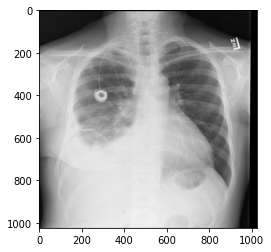

In [53]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-10]) # taking the 8th image from the last, we already know first 80% used for traing and last for validation
plt.imshow(effusion,cmap='gray')

In [54]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.66109395, 0.338906  ]], dtype=float32)

In [55]:
max_val=np.argmax(val_model.predict(img[np.newaxis,:]))
max_val

0

In [56]:
disease_cls[max_val]

'effusion'